In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as sts
from tqdm import tqdm
from sklearn import metrics
from datetime import timedelta
from numpy import linalg
import statsmodels

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_acf_pacf(timeseries):
    """
    Функция, отображающая график временного ряда, 
    автокорреляционную функцию(ACF)
    и частную автокорреляционную функцию(PACF).
    """
    fig = plt.figure(figsize=(16,20))
    
    ax0 = fig.add_subplot(311)
    timeseries.plot(ax=ax0)
    ax0.set_title('График временного ряда')
    ax0.set_xlabel('Дата')
    ax0.set_ylabel('Количество новых заболеваний')
    
    ax1 = fig.add_subplot(312)
    fig = sm.graphics.tsa.plot_acf(timeseries, ax=ax1)
    ax1.set_title('Автокорреляционная функция')
    
    ax2 = fig.add_subplot(313)
    fig = sm.graphics.tsa.plot_pacf(timeseries, ax=ax2)
    ax2.set_title('Частная автокорреляционная функция')

def adf_test(timeseries):
    pvalue = sm.tsa.stattools.adfuller(timeseries)[1]
    print("Критерий Дики-Фуллера: p=%f" % pvalue)
    if pvalue > 0.05:
        print("Ряд нестационарен, нужно большее d")
    else:
        print("Ряд стационарен, d подходит")
    pvalue = sm.tsa.stattools.adfuller(timeseries, regression='c')[1]
    print("Критерий Дики-Фуллера с константой: p=%f" % pvalue)
    if pvalue > 0.05:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")
    pvalue = sm.tsa.stattools.adfuller(timeseries, regression='ct')[1]
    print("Критерий Дики-Фуллера с константой и трендом: p=%f" % pvalue)
    if pvalue > 0.05:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")
    pvalue = sm.tsa.stattools.adfuller(timeseries, regression='ctt')[1]
    print("Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=%f" % pvalue)
    if pvalue > 0.05:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")
    pvalue = sm.tsa.stattools.adfuller(timeseries, regression='nc')[1]
    print("Критерий Дики-Фуллера без константы и тренда: p=%f" % pvalue)
    if pvalue > 0.05:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")

In [3]:
# функция с построением моделей
def adf_test3(timeseries):
    dif_1 = ts.diff().dropna()  
    print('\nШАГ 1')
    print('\nОцениваем модель авторегрессии 1го порядка с трендом и константой')
    print(statsmodels.tsa.ar_model.AutoReg(timeseries,lags=1,trend='ct').fit().summary())
    # проверка гипотезы о равенсте коэф авторегрессии 0
    pvalue = sm.tsa.stattools.adfuller(timeseries, regression='ct')[1]
    print("\nКритерий Дики-Фуллера с константой и линейным трендом (о равенсте коэф авторегрессии 0): p=%f" % pvalue)
    if pvalue < 0.05:
        print("\nРяд класса TS")  
    else:
        # нулевая гипотеза принимается 
        print('\nСтроим модель только с трендом и конст, чтобы убедиться, что правильно включили тренд')
        print(statsmodels.tsa.ar_model.AutoReg(dif_1,lags=0,trend='ct').fit().summary()) 
        print("\nЕсли коэффициент при тренде значим, ряд класса DS (случайное блуждание с дрейфом и детерминированным трендом)")         
    
    print('\nШАГ 2')
    print('\nОцениваем модель авторегрессии 1го порядка с константой')
    print(statsmodels.tsa.ar_model.AutoReg(timeseries,lags=1,trend='c').fit().summary())
    # проверка гипотезы о равенсте коэф авторегрессии 0
    pvalue = sm.tsa.stattools.adfuller(timeseries, regression='c')[1]
    print("\nКритерий Дики-Фуллера с константой (о равенсте коэф авторегрессии 0): p=%f" % pvalue)
    if pvalue > 0.05:
        # нулевая гипотеза принимается  
        print('\nСтроим модель только с конст, чтобы убедиться, что правильно включили конст')
        print(statsmodels.tsa.ar_model.AutoReg(dif_1,lags=0,trend='c').fit().summary())
        print("\nЕсли коэффициент при константе значим, ряд класса DS (случайное блуждание с дрейфом)")
    else:
        print("\nРяд класса TS (стационарный ряд с ненулевой средней)")
 
    print('\nШАГ 3')
    print('\nОцениваем модель авторегрессии 1го порядка без константы')
    print(statsmodels.tsa.ar_model.AutoReg(timeseries,lags=1,trend='n').fit().summary())
    # проверка гипотезы о равенсте коэф авторегрессии 0
    pvalue = sm.tsa.stattools.adfuller(timeseries, regression='nc')[1]
    print("\nКритерий Дики-Фуллера без константы и тренда (о равенсте коэф авторегрессии 0): p=%f" % pvalue)
    if pvalue > 0.05:
        # нулевая гипотеза принимается 
        print("\nРяд класса DS (случайное блуждание без дрейфа)")  
    else:
        print("\nРяд класса TS (процесс AR с нулевым мат ожиданием)")

# Загрузка данных

In [39]:
# румыния
ts = pd.read_excel('COVID_data.xlsx', sheet_name='Romania', index_col='date', parse_dates=['date'])['new_cases'].dropna() #!!!!!!!!!!
ts_new = ts.iloc[-32:-1]
ts = ts[:-15]
print(f"Длина временного ряда: {ts.shape[0]}")
ts = ts.resample('1W').mean()[:-1]
ts.head(15)

Длина временного ряда: 653


date
2020-03-01      0.600000
2020-03-08      1.714286
2020-03-15     16.571429
2020-03-22     43.142857
2020-03-29    197.428571
2020-04-05    292.714286
2020-04-12    348.000000
2020-04-19    349.428571
2020-04-26    327.142857
2020-05-03    303.857143
2020-05-10    314.142857
2020-05-17    215.571429
2020-05-24    171.285714
2020-05-31    169.571429
2020-06-07    174.571429
Freq: W-SUN, Name: new_cases, dtype: float64

In [5]:
ts_new = ts_new.resample('1W').mean()[:-1]
ts_new

date
2021-11-28    2116.333333
2021-12-05    1298.142857
2021-12-12    1016.142857
2021-12-19     722.285714
Freq: W-SUN, Name: new_cases, dtype: float64

In [7]:
# ЕАО
# ts = pd.read_excel('COVID_data.xlsx', sheet_name='EAO', index_col='date', parse_dates=['date'])['new_cases'].dropna() # !!!!!!!!!!
# print(f"Длина временного ряда: {ts.shape[0]}")
# ts_new = ts[-32:-1]
# ts = ts[:-14]
# ts = ts.resample('1W').mean()[:-1]
# ts.head(15)

In [41]:
ts_new = ts_new.resample('1W').mean()[:-1]
ts_new

date
2021-11-28    2116.333333
2021-12-05    1298.142857
2021-12-12    1016.142857
2021-12-19     722.285714
Freq: W-SUN, Name: new_cases, dtype: float64

Text(0, 0.5, 'Количество новых заболеваний')

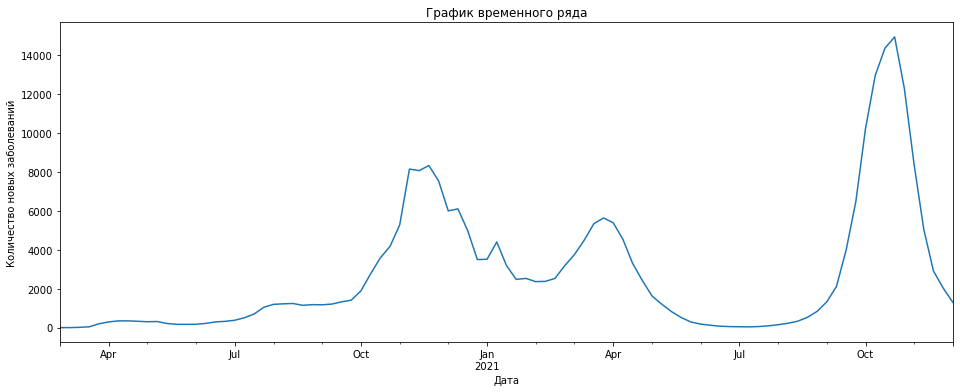

In [7]:
fig = plt.figure(figsize=(16,20))
    
ax0 = fig.add_subplot(311)
ts.plot(ax=ax0)
ax0.set_title('График временного ряда')
ax0.set_xlabel('Дата')
ax0.set_ylabel('Количество новых заболеваний')

# Определение типа ряда

In [8]:
adf_test3(ts)


ШАГ 1

Оцениваем модель авторегрессии 1го порядка с трендом и константой
                            AutoReg Model Results                             
Dep. Variable:              new_cases   No. Observations:                   93
Model:                     AutoReg(1)   Log Likelihood                -769.269
Method:               Conditional MLE   S.D. of innovations           1035.542
Date:                Mon, 27 Dec 2021   AIC                             13.972
Time:                        10:17:17   BIC                             14.082
Sample:                    03-08-2020   HQIC                            14.017
                         - 12-05-2021                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept      167.5701    221.368      0.757      0.449    -266.304     601.444
trend           -0.2781      4.490     -0.062      

# Определение порядка разности d и компонент p, q.

### График временного ряда, АКФ и ЧАКФ

Критерий Дики-Фуллера: p=0.000405
Ряд стационарен, d подходит
Критерий Дики-Фуллера с константой: p=0.000405
Ряд стационарен
Критерий Дики-Фуллера с константой и трендом: p=0.000995
Ряд стационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=0.004899
Ряд стационарен
Критерий Дики-Фуллера без константы и тренда: p=0.167253
Ряд нестационарен


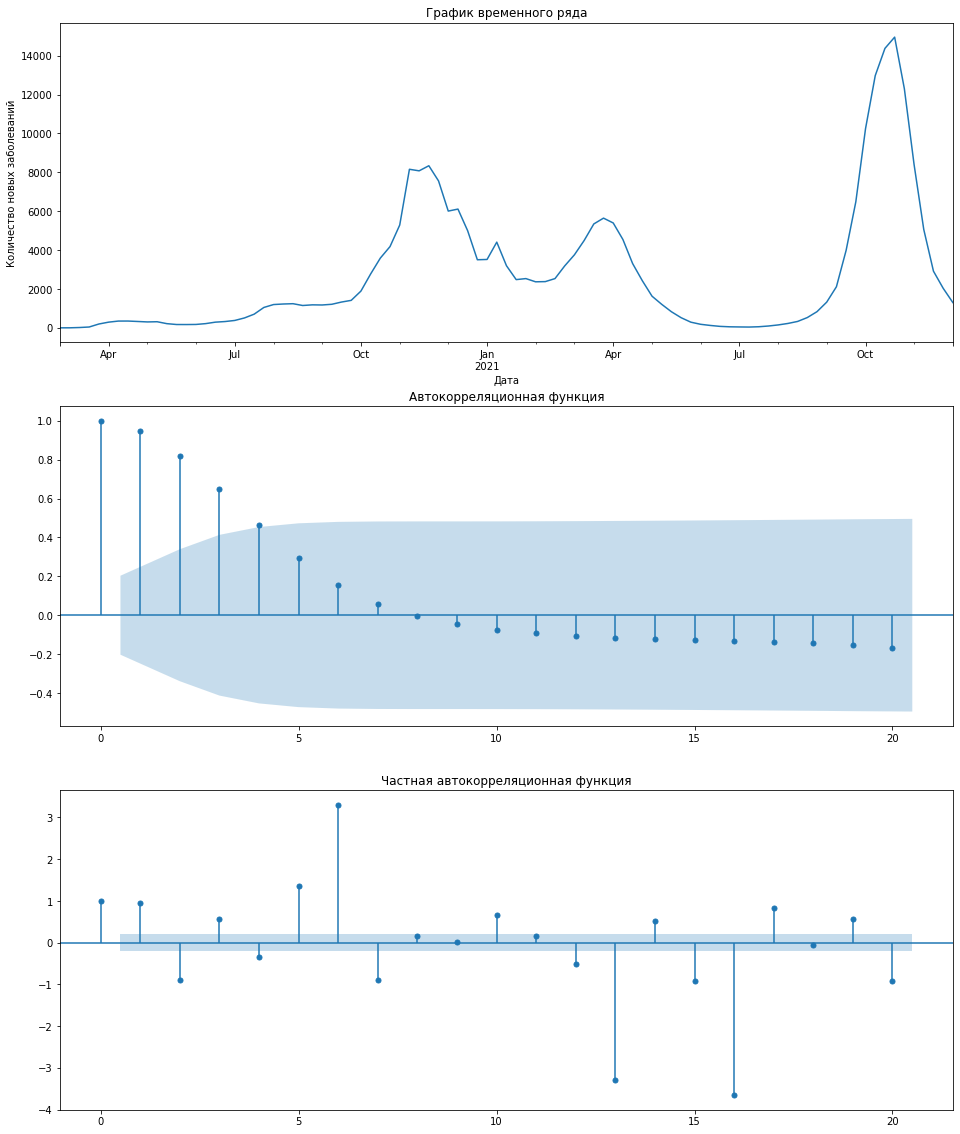

In [9]:
adf_test(ts)
plot_acf_pacf(ts)

### График первых разностей

Критерий Дики-Фуллера: p=0.000001
Ряд стационарен, d подходит
Критерий Дики-Фуллера с константой: p=0.000001
Ряд стационарен
Критерий Дики-Фуллера с константой и трендом: p=0.000015
Ряд стационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=0.000096
Ряд стационарен
Критерий Дики-Фуллера без константы и тренда: p=0.000000
Ряд стационарен


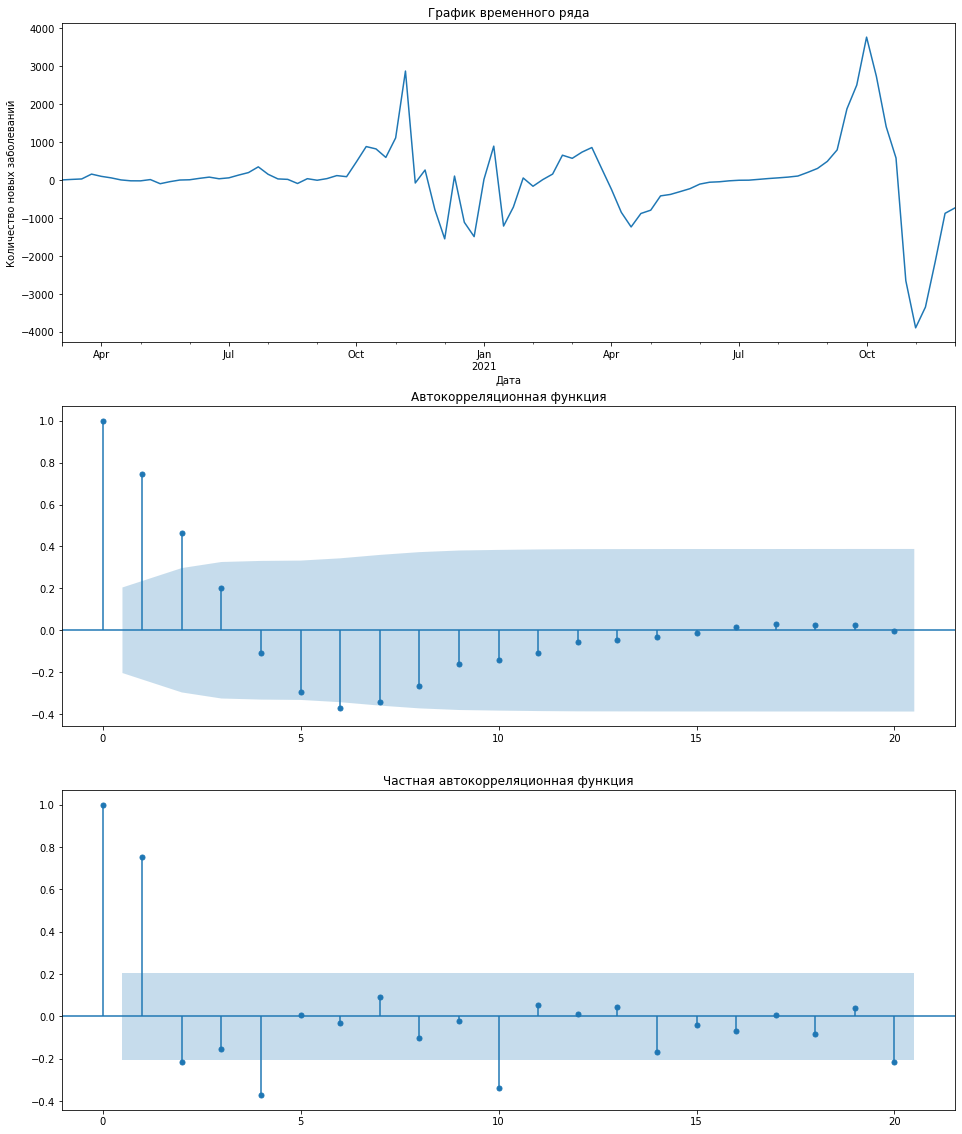

In [10]:
dif_1 = ts.diff().dropna()
adf_test(dif_1)
plot_acf_pacf(dif_1)

### График вторых разностей

Критерий Дики-Фуллера: p=0.000000
Ряд стационарен, d подходит
Критерий Дики-Фуллера с константой: p=0.000000
Ряд стационарен
Критерий Дики-Фуллера с константой и трендом: p=0.000001
Ряд стационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=0.000004
Ряд стационарен
Критерий Дики-Фуллера без константы и тренда: p=0.000000
Ряд стационарен


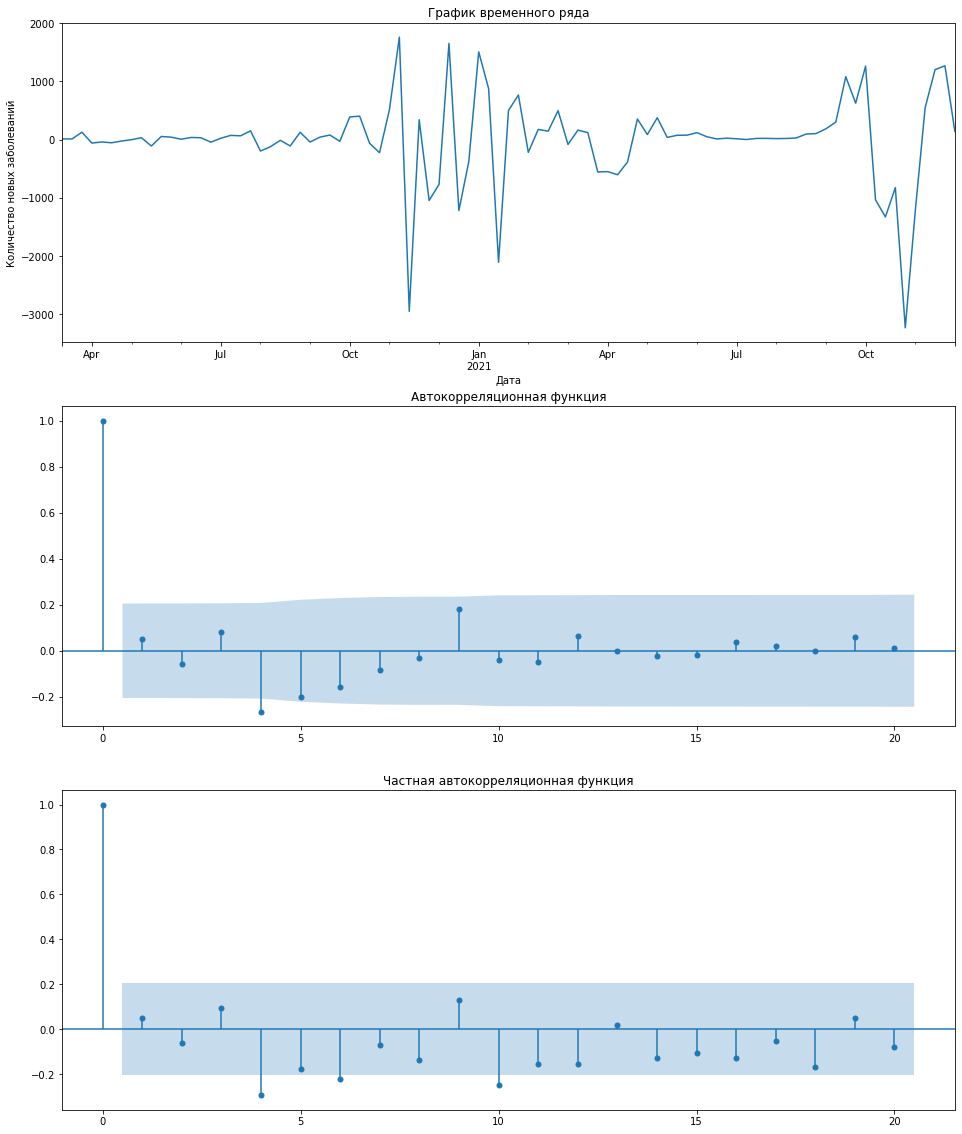

In [11]:
dif_2 = ts.diff().diff().dropna()
adf_test(dif_2)
plot_acf_pacf(dif_2)

### p и q определяются по графикам АКФ и ЧАКФ для подходящего значения d

# Оценка параметров моделей

* Log Lokehood - логарифм правдоподобия
* S.D. of inovations - стандартная ошибка модели
* AIC - информационный критерий Аккаике
* BIC - информационный критерий Байеса
* HQIC - информационный критерий Хеннана-Куинна
* coef - значение коэффициента
* P>|z| - p-value для гипотезы о незначимости коэффициента (если больше 0.05 - незначим)

# Поиск 5 лучших моделей: перебор параметров

In [23]:
d = range(0, 4)
q = range(0, 8)
p = range(0, 8)

from itertools import product

parameters = list(product(p,d,q))
len(parameters)

256

In [24]:
# Может выполняться несколько минут
results = []
best_bic = float("inf")

for param in tqdm(parameters):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.ARIMA(ts, order=param).fit()
    except (ValueError, linalg.LinAlgError):
        continue
    bic = model.bic
    #сохраняем лучшую модель, bic, параметры
    if bic < best_bic:
        best_model = model
        best_bic = bic
        best_param = param
    results.append([param, model.bic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'bic']
result_table.sort_values(by = 'bic', ascending=True).head(5)

100%|██████████| 256/256 [04:19<00:00,  1.01s/it]


,parameters,bic
89,"(4, 2, 1)",1468.279023
14,"(0, 2, 4)",1470.311923
56,"(2, 2, 4)",1470.581801
16,"(0, 2, 6)",1471.071851
35,"(1, 2, 4)",1471.193863


### Для начала поработаем с лучшей моделью (можно указать любую модель из 5)

In [25]:
model = sm.tsa.ARIMA(ts, order=(4, 2, 1)).fit() # !!!!!!!!!!!
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D2.new_cases   No. Observations:                   91
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -718.352
Method:                       css-mle   S.D. of innovations            632.522
Date:                Mon, 27 Dec 2021   AIC                           1450.703
Time:                        10:26:19   BIC                           1468.279
Sample:                    03-15-2020   HQIC                          1457.794
                         - 12-05-2021                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.6285      5.279     -0.119      0.905     -10.975       9.718
ar.L1.D2.new_cases     0.8137      0.097      8.364      0.000       0.623       1.004
ar.L2.D2.new_cases    -0.0981      0.129     -0.760      0.447      -0.351       0.155
ar.L3.D2.new_cases     0.1674      0.128      1.310      0.190      -0.083       0.418
ar.L4.D2.new_cases    -0.3675      0.102     -3.593      0.000      -0.568      -0.167
ma.L1.D2.new_cases    -1.0000      0.031    -32.213      0.000      -1.061      -0.939
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0058           -0.5320j            1.1378           -0.0774
AR.2            1.0058           +0.5320j            1.1378            0.0774
AR.3           -0.7779           -1.2235j            1.4499           -0.3401
AR.4           -0.7779           +1.2235j            1.4499            0.3401
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

---

# Проверка адекватности модели

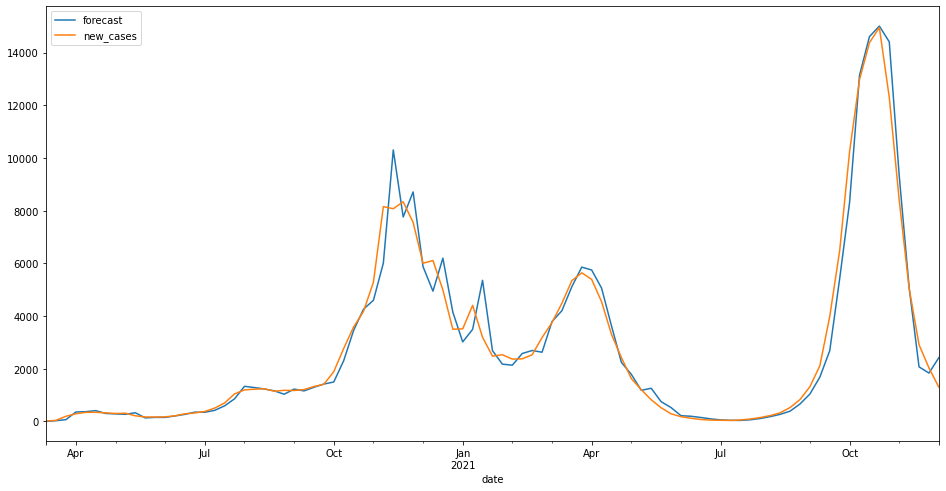

In [26]:
fig, ax = plt.subplots(figsize=(16,8))
model.plot_predict(ax=ax)
fig.show()

In [27]:
pred = model.predict(typ='levels')
print('MSE =', metrics.mean_squared_error(ts[2:], pred))
print('RMSE =', np.sqrt(metrics.mean_squared_error(ts[2:], pred)))
print('MAE =', metrics.mean_absolute_error(ts[2:], pred))
print('MAPE =', metrics.mean_absolute_percentage_error(ts[2:], pred))
print('R2 =', metrics.r2_score(ts[2:], pred))

MSE = 408549.2194701248
RMSE = 639.1785505397727
MAE = 357.24651024550207
MAPE = 0.19907218222774453
R2 = 0.9635308304224197


# Проверка нормальности остатков

Критерий Дики-Фуллера: p=1.000000
Ряд нестационарен, нужно большее d
Критерий Дики-Фуллера с константой: p=1.000000
Ряд нестационарен
Критерий Дики-Фуллера с константой и трендом: p=1.000000
Ряд нестационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=1.000000
Ряд нестационарен
Критерий Дики-Фуллера без константы и тренда: p=0.999494
Ряд нестационарен


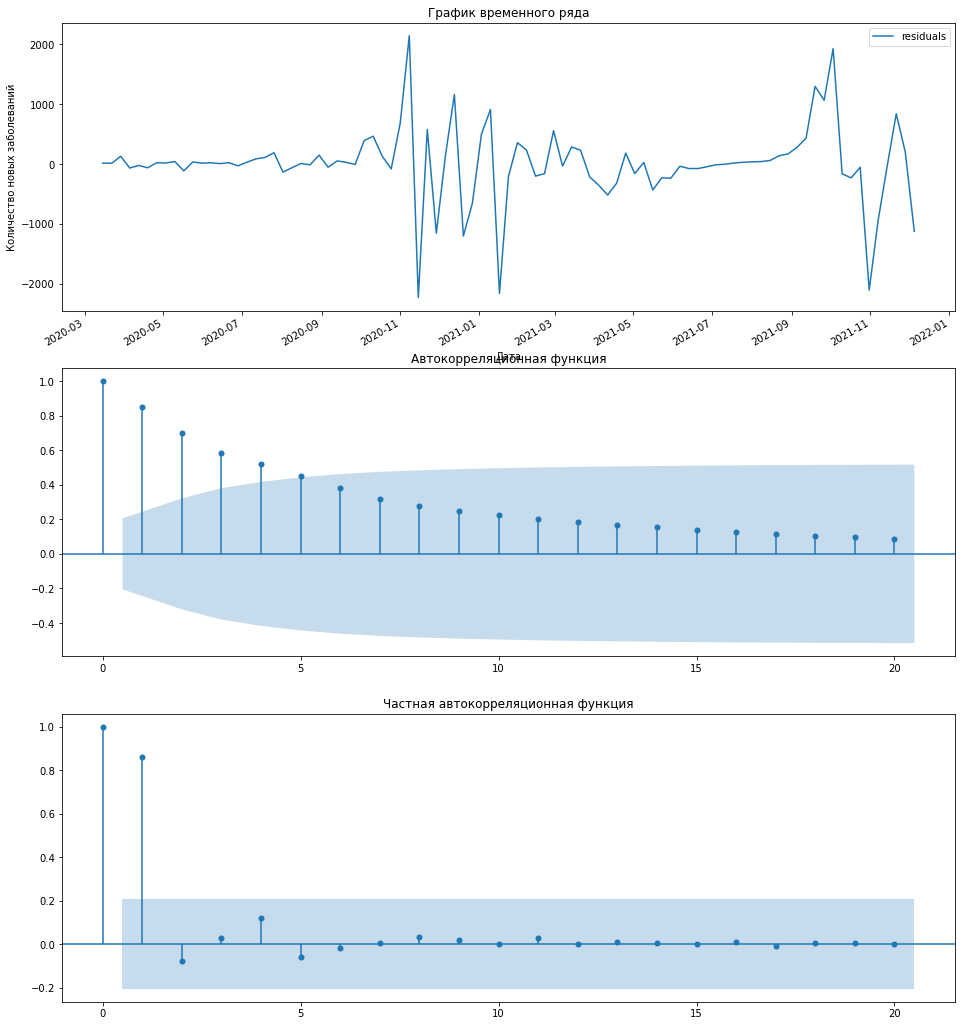

In [28]:
resid = pd.DataFrame(model.resid, columns=['residuals']).sort_values(by='residuals')
adf_test(resid)
plot_acf_pacf(resid)

Тест на нормальность: p = 0.000024
Распределение остатков ненормальное


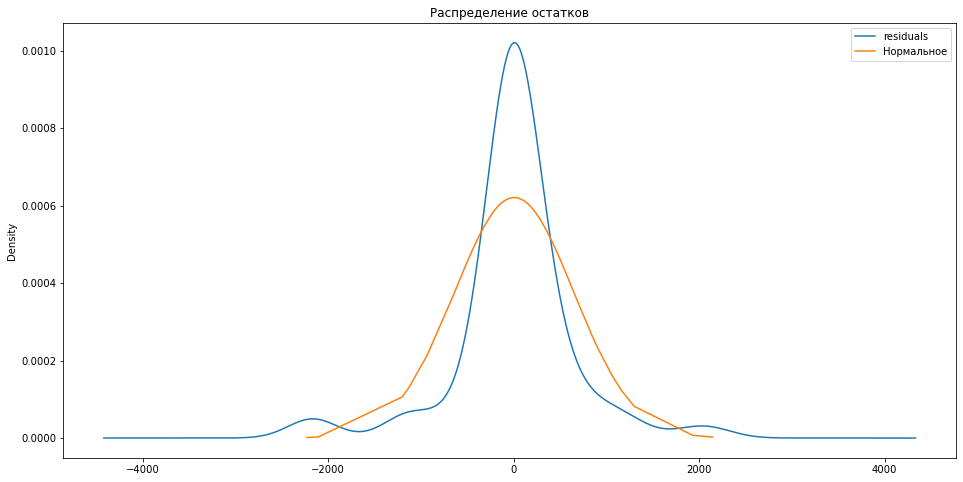

In [29]:
pvalue = sts.normaltest(resid['residuals'])[1]
print("Тест на нормальность: p = %f" % pvalue)
if pvalue > 0.05:
    print("Распределение остатков нормальное")
else:
    print("Распределение остатков ненормальное")

fig, ax = plt.subplots(figsize=(16,8))
resid.plot.kde(ax=ax)
plt.title('Распределение остатков')
plt.plot(resid, sts.norm.pdf(resid, resid.mean(), resid.std()), label='Нормальное')
plt.legend()
fig.show()

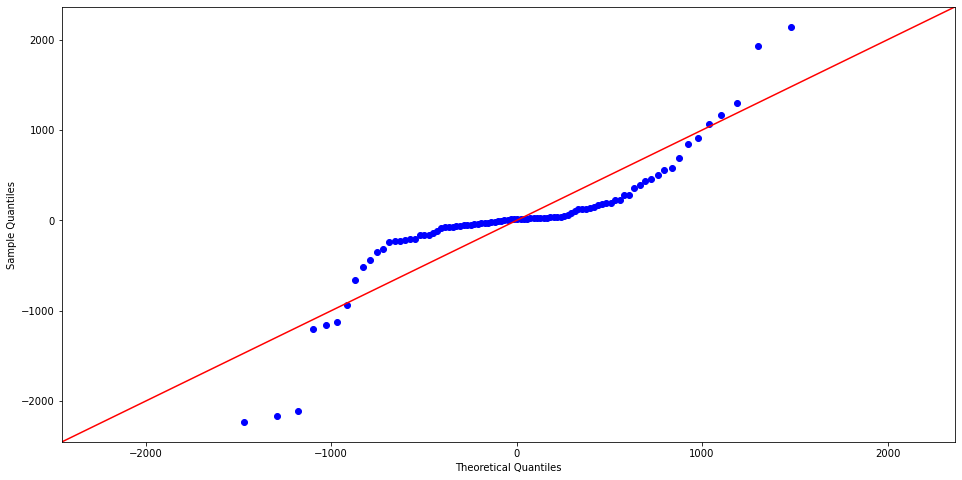

In [30]:
fig, ax = plt.subplots(figsize=(16,8))
sm.qqplot(resid['residuals'], loc=resid['residuals'].mean(), scale = resid['residuals'].std(), line='45', ax=ax)
fig.show()

# Предсказание будущих показателей

In [31]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D2.new_cases   No. Observations:                   91
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -718.352
Method:                       css-mle   S.D. of innovations            632.522
Date:                Mon, 27 Dec 2021   AIC                           1450.703
Time:                        10:26:26   BIC                           1468.279
Sample:                    03-15-2020   HQIC                          1457.794
                         - 12-05-2021                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.6285      5.279     -0.119      0.905     -10.975       9.718
ar.L1.D2.new_cases     0.8137      0.097      8.364      0.000       0.623       1.004
ar.L2.D2.new_cases    -0.0981      0.129     -0.760      0.447      -0.351       0.155
ar.L3.D2.new_cases     0.1674      0.128      1.310      0.190      -0.083       0.418
ar.L4.D2.new_cases    -0.3675      0.102     -3.593      0.000      -0.568      -0.167
ma.L1.D2.new_cases    -1.0000      0.031    -32.213      0.000      -1.061      -0.939
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0058           -0.5320j            1.1378           -0.0774
AR.2            1.0058           +0.5320j            1.1378            0.0774
AR.3           -0.7779           -1.2235j            1.4499           -0.3401
AR.4           -0.7779           +1.2235j            1.4499            0.3401
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

Последняя дата во временном ряду:  2021-12-05 00:00:00
Предсказание на 2 недели, до: 2021-12-19 00:00:00


<AxesSubplot:xlabel='date'>

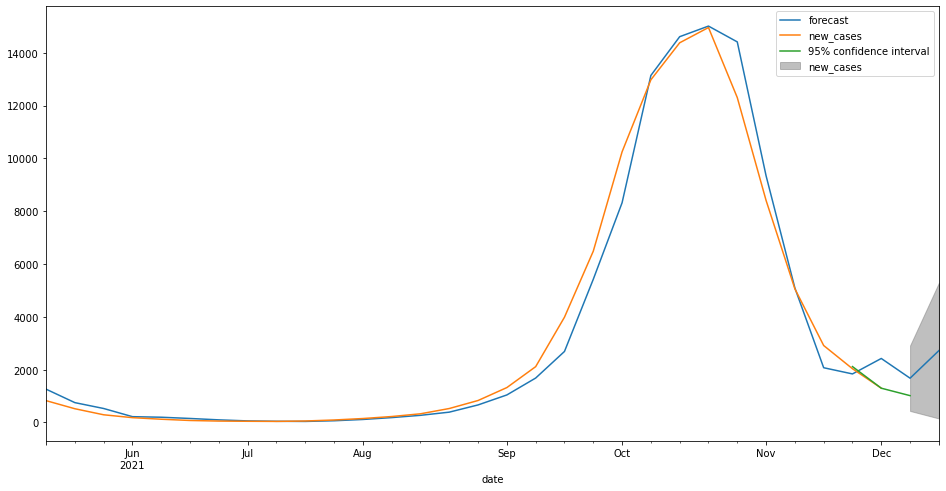

In [32]:
weeks_pred = 2 # количество недель для предсказания !!!!!!!!!!!!!
print("Последняя дата во временном ряду: ", ts.index[-1])
print(f"Предсказание на {weeks_pred} недели, до: {ts.index[-1] + timedelta(weeks=weeks_pred)}")

fig, ax = plt.subplots(figsize=(16,8))
model.plot_predict(start=ts.index[-30], end=(ts.index[-1] + timedelta(weeks=weeks_pred)), ax=ax)
fig.show()
ts_new.plot(legend=True)

In [33]:
pred = model.predict(start=ts.index[-1] + timedelta(days=1), end=(ts.index[-1] + timedelta(weeks=weeks_pred)), typ='levels')
pred

2021-12-12    1676.652251
2021-12-19    2720.103810
Freq: W-SUN, dtype: float64

# Соберем ансамбль предсказаний

In [34]:
result_table.sort_values(by = 'bic', ascending=True).head(5)

,parameters,bic
89,"(4, 2, 1)",1468.279023
14,"(0, 2, 4)",1470.311923
56,"(2, 2, 4)",1470.581801
16,"(0, 2, 6)",1471.071851
35,"(1, 2, 4)",1471.193863


## Меняем параметры моделей на табличные

In [35]:
model1 = sm.tsa.ARIMA(ts, order=(2, 1, 0)).fit()
model2 = sm.tsa.ARIMA(ts, order=(0, 1, 2)).fit()
model3 = sm.tsa.ARIMA(ts, order=(3, 1, 0)).fit()
model4 = sm.tsa.ARIMA(ts, order=(2, 1, 1)).fit()
model5 = sm.tsa.ARIMA(ts, order=(0, 2, 3)).fit()

## Сохраняем предсказания ансамбля и доверительные интервалы в Excel-файл

In [37]:
ts_new

date
2021-11-28    2116.333333
2021-12-05    1298.142857
2021-12-12    1016.142857
Freq: W-SUN, Name: new_cases, dtype: float64

In [57]:
forecast = pd.DataFrame(index=pred.index)
res1 = model1.forecast(weeks_pred)
res2 = model2.forecast(weeks_pred)
res3 = model3.forecast(weeks_pred)
res4 = model4.forecast(weeks_pred)
res5 = model5.forecast(weeks_pred)
forecast['value1'] = res1[0]
forecast['value2'] = res2[0]
forecast['value3'] = res3[0]
forecast['value4'] = res4[0]
forecast['value5'] = res5[0]
forecast['result'] = (forecast['value1']+forecast['value2']+forecast['value3']+forecast['value4']+forecast['value5'])/5
forecast['left_border'] = [x[0] for x in res1[2]]
forecast['right_border'] = [x[1] for x in res1[2]]
forecast['real_value'] = ts_new[-2:]
forecast['sarima_forecast'] = pred
forecast.to_excel('forecast.xlsx')
forecast

,value1,value2,value3,value4,value5,result,left_border,right_border,real_value,sarima_forecast
2021-12-12,816.380124,828.419429,1024.687242,1068.241467,1175.521543,982.649961,-521.294736,2154.054984,1016.142857,1793.332801
2021-12-19,534.367923,835.359973,970.353234,1265.207026,1054.487927,931.955217,-2328.508621,3397.244468,722.285714,2473.997518


In [58]:
ts_new

date
2021-11-28    2116.333333
2021-12-05    1298.142857
2021-12-12    1016.142857
2021-12-19     722.285714
Freq: W-SUN, Name: new_cases, dtype: float64

# Добавим сезонность и построим SARIMA

Общий вид модели - **SARIMA (p,d,q) (P,D,Q) s**

* p - порядок модели AR
* d - порядок интегрирования
* q - порядок модели MA
* P - порядок сезонной составляющей SAR
* D - порядок интегрирования сезонной составляющей
* Q - порядок сезонной составляющей SMA
* s - размерность сезонности

### Для начала надо провести сдвиг по сезонности, можно попробовать разные, рекомендуемый 4-6 месяцев.

Сезонная разность:
Критерий Дики-Фуллера: p=0.026340
Ряд стационарен, d подходит
Критерий Дики-Фуллера с константой: p=0.026340
Ряд стационарен
Критерий Дики-Фуллера с константой и трендом: p=0.112089
Ряд нестационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=0.163777
Ряд нестационарен
Критерий Дики-Фуллера без константы и тренда: p=0.002605
Ряд стационарен
------------------------------
Интегрированная сезонная разность:
Критерий Дики-Фуллера: p=0.000283
Ряд стационарен, d подходит
Критерий Дики-Фуллера с константой: p=0.000283
Ряд стационарен
Критерий Дики-Фуллера с константой и трендом: p=0.002353
Ряд стационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=0.104903
Ряд нестационарен
Критерий Дики-Фуллера без константы и тренда: p=0.000012
Ряд стационарен


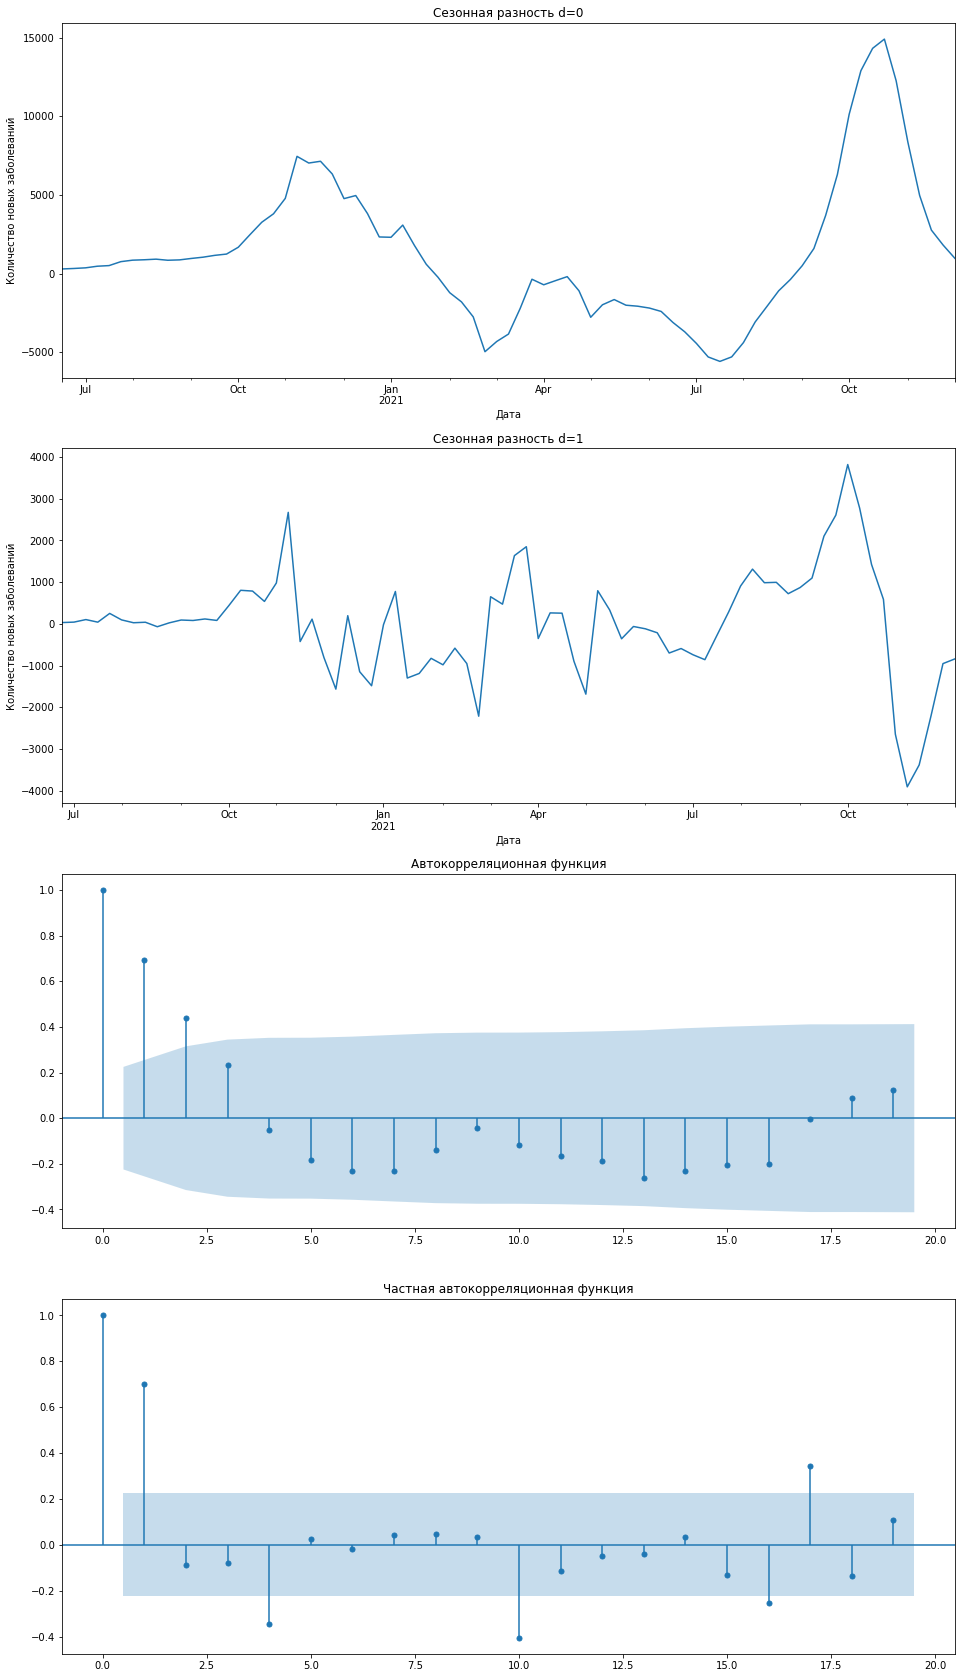

In [43]:
months_seasonal = 4 # !!!!!!!!!!!!


ts_4m = ts.diff(4*months_seasonal).dropna()
print("Сезонная разность:")
adf_test(ts_4m)

print("-"*30)
dif_4m = ts.diff(4*months_seasonal).diff().dropna()
print("Интегрированная сезонная разность:")
adf_test(dif_4m)

# dif2_4m = ts.diff(30*months_seasonal).diff().diff().dropna()
# adf_test(dif2_4m)

fig = plt.figure(figsize=(16,30))
    
ax0 = fig.add_subplot(411)
ts_4m.plot(ax=ax0)
ax0.set_title('Сезонная разность d=0')
ax0.set_xlabel('Дата')
ax0.set_ylabel('Количество новых заболеваний')

ax0 = fig.add_subplot(412)
dif_4m.plot(ax=ax0)
ax0.set_title('Сезонная разность d=1')
ax0.set_xlabel('Дата')
ax0.set_ylabel('Количество новых заболеваний')

ax1 = fig.add_subplot(413)
fig = sm.graphics.tsa.plot_acf(dif_4m, ax=ax1)
ax1.set_title('Автокорреляционная функция')

ax2 = fig.add_subplot(414)
fig = sm.graphics.tsa.plot_pacf(dif_4m, ax=ax2)
ax2.set_title('Частная автокорреляционная функция')

fig.show()

### P и Q определяются по графикам АКФ и ЧАКФ для подходящего значения D сезонной разности

In [44]:
%%time 

#Модель SARIMA может тренироваться долго - если ставить значения параметров больше 1 время растет в геометрической прогресии... 

p = 4
d = 2
q = 1
P = 1
D = 1
Q = 1
s = 4*months_seasonal

sarima = sm.tsa.statespace.SARIMAX(ts, order=(p, d, q), 
                                seasonal_order=(P, D, Q, s)).fit()
print(sarima.summary()) 

                                     SARIMAX Results                                      
Dep. Variable:                          new_cases   No. Observations:                   93
Model:             SARIMAX(4, 2, 1)x(1, 1, 1, 16)   Log Likelihood                -604.476
Date:                            Mon, 27 Dec 2021   AIC                           1224.952
Time:                                    10:28:31   BIC                           1243.492
Sample:                                03-01-2020   HQIC                          1232.355
                                     - 12-05-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7900      0.093      8.531      0.000       0.609       0.972
ar.L2         -0.0916      0.149   

---

# Проверка адекватности сезонной модели

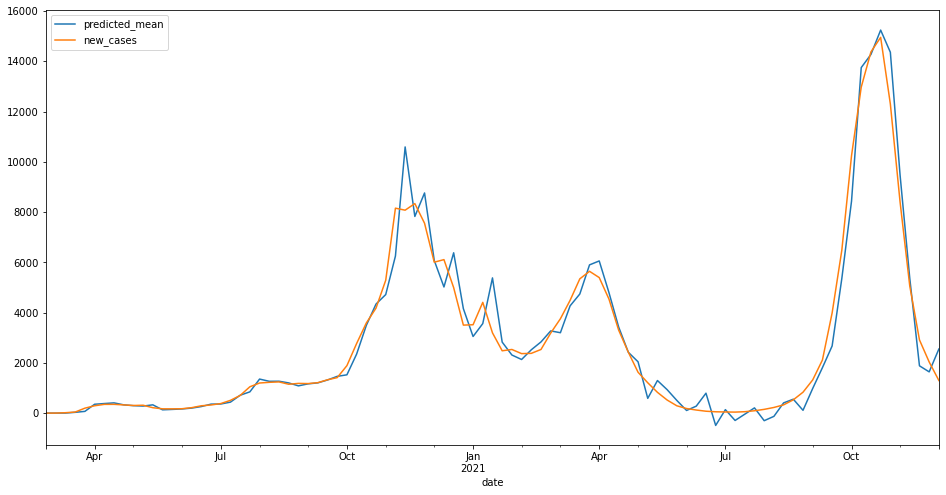

In [45]:
fig, ax = plt.subplots(figsize=(16,8))
pred = sarima.predict(typ='levels')
pred.plot(ax=ax)
ts.plot(ax=ax)
plt.legend()
fig.show()

In [46]:
print('MSE =', metrics.mean_squared_error(ts, pred))
print('RMSE =', np.sqrt(metrics.mean_squared_error(ts, pred)))
print('MAE =', metrics.mean_absolute_error(ts, pred))
print('MAPE =', metrics.mean_absolute_percentage_error(ts, pred))
print('R2 =', metrics.r2_score(ts, pred))

MSE = 448003.2365606827
RMSE = 669.3304389915961
MAE = 407.52423084345133
MAPE = 0.6008930523061241
R2 = 0.9597371533742225


# Проверка нормальности остатков

Критерий Дики-Фуллера: p=1.000000
Ряд нестационарен, нужно большее d
Критерий Дики-Фуллера с константой: p=1.000000
Ряд нестационарен
Критерий Дики-Фуллера с константой и трендом: p=1.000000
Ряд нестационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=1.000000
Ряд нестационарен
Критерий Дики-Фуллера без константы и тренда: p=1.000000
Ряд нестационарен


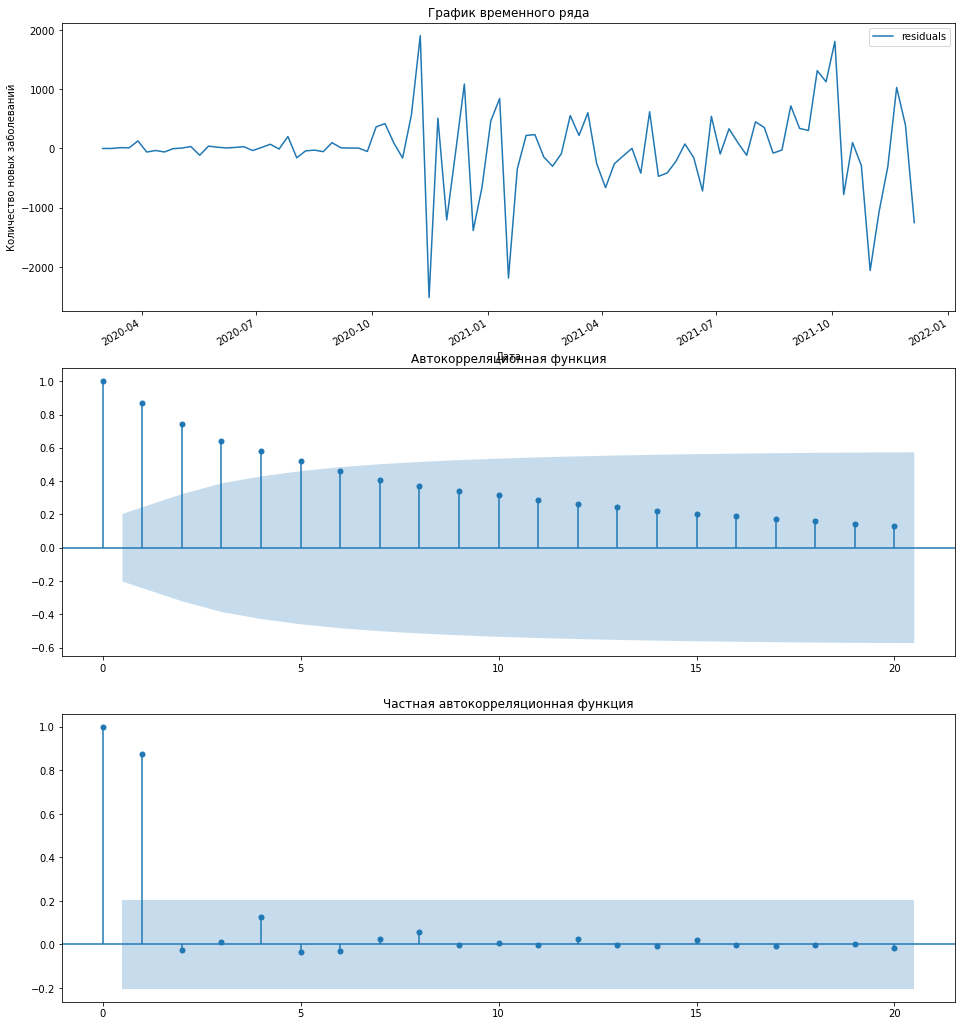

In [47]:
resid = pd.DataFrame(sarima.resid, columns=['residuals']).sort_values(by='residuals')
adf_test(resid)
plot_acf_pacf(resid)

Тест на нормальность: p = 0.000013
Распределение остатков ненормальное


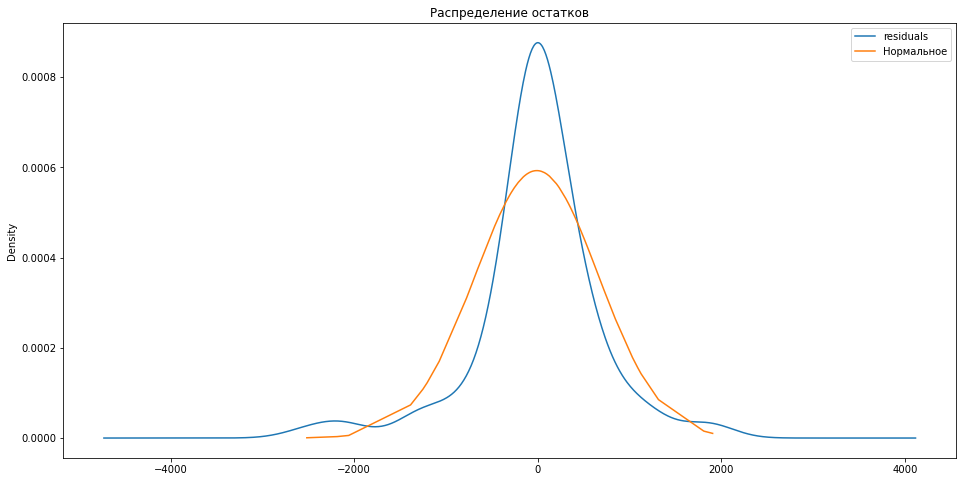

In [48]:
pvalue = sts.normaltest(resid['residuals'])[1]
print("Тест на нормальность: p = %f" % pvalue)
if pvalue > 0.05:
    print("Распределение остатков нормальное")
else:
    print("Распределение остатков ненормальное")

fig, ax = plt.subplots(figsize=(16,8))
resid.plot.kde(ax=ax)
plt.title('Распределение остатков')
plt.plot(resid, sts.norm.pdf(resid, resid.mean(), resid.std()), label='Нормальное')
plt.legend()
fig.show()

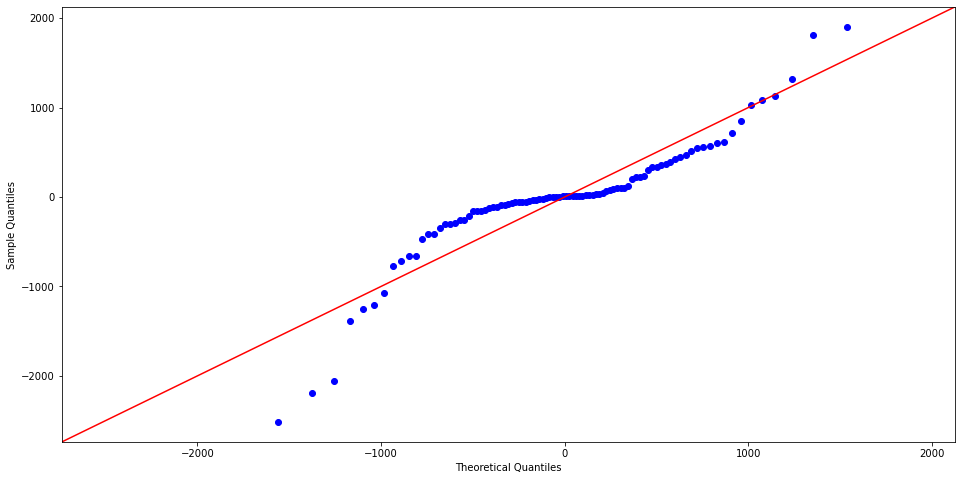

In [52]:
fig, ax = plt.subplots(figsize=(16,8))
sm.qqplot(resid['residuals'], loc=resid['residuals'].mean(), scale = resid['residuals'].std(), line='45', ax=ax)
fig.show()

# Предсказание будущих показателей

In [53]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          new_cases   No. Observations:                   93
Model:             SARIMAX(4, 2, 1)x(1, 1, 1, 16)   Log Likelihood                -604.476
Date:                            Mon, 27 Dec 2021   AIC                           1224.952
Time:                                    10:28:46   BIC                           1243.492
Sample:                                03-01-2020   HQIC                          1232.355
                                     - 12-05-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7900      0.093      8.531      0.000       0.609       0.972
ar.L2         -0.0916      0.149     -0.615      0.539      -0.383       0.200
ar.L3          0.1553      0.150      1.032      0.302      -0.140       0.450
ar.L4         -0.3390      0.119     -2.857      0.004      -0.571      -0.106
ma.L1         -0.9999      4.786     -0.209      0.835     -10.380       8.380
ar.S.L16      -0.0408      0.311     -0.131      0.896      -0.651       0.570
ma.S.L16      -0.9738      5.017     -0.194      0.846     -10.807       8.859
sigma2      4.145e+05    9.3e-06   4.46e+10      0.000    4.14e+05    4.14e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                18.51
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                            -0.61
Prob(H) (two-sided):                  0.39   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.38e+27. Standard errors may be unstable.
"""

Последняя дата во временном ряду:  2021-12-05 00:00:00
Предсказание на 2 недели, до: 2021-12-19 00:00:00


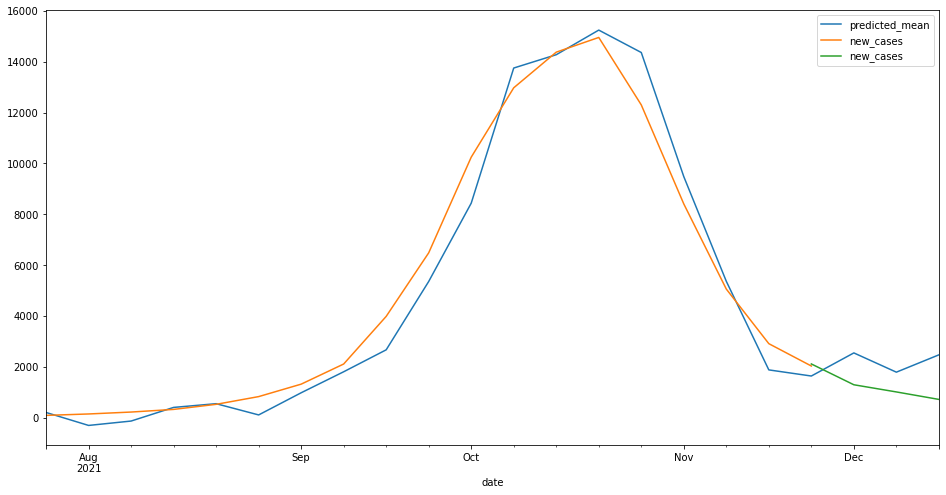

In [54]:
weeks_pred = 2 # количество недель для предсказания !!!!!!!!!!!!!

print("Последняя дата во временном ряду: ", ts.index[-1])
print(f"Предсказание на {weeks_pred} недели, до: {ts.index[-1] + timedelta(weeks=weeks_pred)}")

fig, ax = plt.subplots(figsize=(16,8))
pred = sarima.predict(start=ts.index[-20], end=(ts.index[-1] + timedelta(weeks=weeks_pred)), typ='levels')
pred.plot(ax=ax)
ts[-20:-1].plot(ax=ax)
ts_new.plot()
plt.legend()
fig.show()

In [55]:
pred = sarima.predict(start=ts.index[-1] + timedelta(days=1), end=(ts.index[-1] + timedelta(weeks=weeks_pred)), typ='levels')
pred

2021-12-12    1793.332801
2021-12-19    2473.997518
Freq: W-SUN, Name: predicted_mean, dtype: float64

## Сохраняем предсказания и доверительные интервалы в Excel-файл

In [56]:
forecast = pd.DataFrame(columns=['value'], index=pred.index)
res = sarima.forecast(weeks_pred)
# forecast['value'] = res
# forecast.to_excel('forecast_sarima.xlsx')
# forecast
res

2021-12-12    1793.332801
2021-12-19    2473.997518
Freq: W-SUN, Name: predicted_mean, dtype: float64